# Code to calculate the layer thickness of tracers in 2x2 degree bins 

In [31]:
import cartopy
import matplotlib.path as mpath
import cartopy.crs as ccrs
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.colors as mcolors
from matplotlib import cm
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
from scipy.interpolate import interp2d
import matplotlib.patches as patches
import matplotlib as mpl

In [32]:
#import the data
df_final = pd.read_csv('csv_files/full_tracer_v15cold.csv')



In [117]:
# new_df = df_final[df_final['Tracer Material'] == 4.0]
# new_df


In [33]:
#convert to arrays
land_longs = np.array(df_final['Landing Longitude'])
land_lats = np.array(df_final['Landing Latitude'])
volume = np.array(df_final['Volume'])
depth = np.array(df_final["Depth"])
pressure = np.array(df_final['Pressure']/10**9)
trm = np.array(df_final['Tracer Material'])
velocity = np.array(df_final['Resultant Velocity'])
launch_angle = np.array(df_final['Launch Angle'])
# land_longs = np.array(new_df['Landing Longitude'])
# land_lats = np.array(new_df['Landing Latitude'])
# volume = np.array(new_df['Volume'])
# depth = np.array(new_df["Depth"])
# pressure = np.array(new_df['Pressure']/10**9)
# trm = np.array(new_df['Tracer Material'])

#note that negative depths are above the surface, positive depths are below
print(velocity.max())


2.3797964740739856


In [34]:
#function to get layer thickness 
def binning(lats, longs, weights):
    final_latitude_bins = np.arange(-80, 81, 2)
    final_longitude_bins = np.arange(-180, 181, 2)

    H, _, _ = np.histogram2d(lats, longs, bins = (final_latitude_bins, final_longitude_bins), weights=weights)
    H_reflected, _, _ = np.histogram2d(lats, -longs, bins = (final_latitude_bins, final_longitude_bins), weights=weights)

    surface_area = abs(1750**2 * np.sin(np.deg2rad(90.5- final_latitude_bins[:-1])) *np.radians(1)* np.radians(1))
    surface_area = np.expand_dims(surface_area, axis=1)
    surface_area = np.repeat(surface_area, 180, axis=1) # make surface area same shape as H      
    layer_thickness = (H+H_reflected) / (surface_area)

    return layer_thickness, final_latitude_bins, final_longitude_bins



In [35]:
def define_ellipse(lat, lon, a, b, rot):
    '''
    Find the coordinates of the edge of an ellipse,
    given the central point, semimajor and semiminor 
    axes and the rotation

    Inputs
    ------
    lat: float
        Central latitude, in degrees
    lon: float
        Central longitude, in degrees
    a: float
        semimajor axes length, in km
    b: float
        semiminor axes length, in km
    rot: float
        angle of rotation of semi-major axes from N-S, in degrees

    Returns
    -------
    ndarray
        Final latitudes, in degrees
    ndarray
        Final longitudes, in degrees
    '''

    # Range of angles to calculate ellipse for
    ang_r = np.radians(np.arange(0, 361, 1))

    # Unrotated ellipse coords
    xs = b * np.cos(ang_r)
    ys = a * np.sin(ang_r)

    # Rotate by desired amount
    rot_r = np.radians(rot)
    xr = xs * np.cos(rot_r) + ys * np.sin(rot_r)
    yr = -xs * np.sin(rot_r) + ys * np.cos(rot_r)

    # Calculate distance and bearing to each point from centre
    dist = np.sqrt(xr**2 + yr**2) / 1750
    brng = np.arctan2(xr, yr)
    brng[xr < 0] += 2 * np.pi

    # Convert central lat/lon to radians
    rlat = np.radians(np.asarray(lat))
    rlon = np.radians(np.asarray(lon))

    # Find final lats and lons for each point on ellipse, using bearing and distance
    final_lat = np.arcsin(np.sin(rlat)*np.cos(dist)
                          + (np.cos(brng)*np.cos(rlat))*np.sin(dist))
    final_lon = (rlon + np.arctan2(np.sin(brng)*np.cos(rlat)*np.sin(dist),
                                   np.cos(dist)-np.sin(rlat)*np.sin(final_lat)))


    return np.degrees(final_lat), np.degrees(final_lon)

## plot layer thickness for all tracers in the data frame:

In [5]:

# layer_thickness = binning(land_lats, land_longs, volume)
# fig, ax = plt.subplots(figsize=(13, 4))
# # ax.pcolormesh(x, y, np.log10(layer_thickness), shading='flat', vmin=Z.min(), vmax=Z.max())
# final_plot = ax.imshow(np.log10(layer_thickness), interpolation='nearest', origin='lower', extent=[-180, 180, -80, 80], cmap = 'magma')
# plt.xlabel('longs')
# plt.ylabel('lats')
# ax.grid()

# cbar = plt.colorbar(final_plot, label='log10 thickness (km) ', aspect=5)
# # cbar = plt.colorbar(layer_thickness, label='volume (km^3) ', aspect=5, cax = fig.add_axes([0.7, 0.2, 0.02, 0.6]))
# # cbar.minorticks_on()
# plt.savefig('thickness.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')

## Makes separate layer thickness plots filtered by each depth range:

In [16]:
# depth_min = 0
# depth_max = 180
# bin_size = 20

# for min_range in np.arange(depth_min, depth_max, bin_size):
#     max_range = min_range + bin_size 
#     min_filter = depth > min_range
#     max_filter = depth < max_range
#     range_filter = min_filter & max_filter #all depths between -180 -160 then -160 to -140
#     filtered_lats = land_lats[range_filter]
#     filtered_longs = land_longs[range_filter]
#     filtered_volume = volume[range_filter]
#     filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
#     filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
    
#     fig, ax = plt.subplots(figsize=(13, 4))
#     # ax.pcolormesh(x, y, np.log10(layer_thickness), shading='flat', vmin=Z.min(), vmax=Z.max())
#     final_plot = ax.imshow((filtered_layer_thickness_log), interpolation='nearest', origin='lower', extent=[-180, 180, -80, 80])
#     plt.xlabel('longs')
#     plt.ylabel('lats')
#     ax.grid()

#     cbar = plt.colorbar(final_plot, label='log10 thickness (km) ', aspect=5)
#     # cbar = plt.colorbar(layer_thickness, label='volume (km^3) ', aspect=5, cax = fig.add_axes([0.7, 0.2, 0.02, 0.6]))
#     # cbar.minorticks_on()
#     plt.savefig(f'Figures/v15/depth_bins/filtered_thickness_({min_range},{max_range}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')
    

## Makes separate layer thickness plots filtered by pressure range:

In [15]:
# pressure_mins = [0, 5, 10, 25, 50, 100]

# pressure_maxs = [5, 10, 25, 50, 100, pressure.max()]

# pressure_tuple = list(zip(pressure_mins,pressure_maxs))

# for min_range, max_range in pressure_tuple:
#     min_filter = pressure > min_range
#     max_filter = pressure < max_range
#     range_filter = min_filter & max_filter #all depths between -180 -160 then -160 to -140
#     filtered_lats = land_lats[range_filter]
#     filtered_longs = land_longs[range_filter]
#     filtered_volume = volume[range_filter]
#     filtered_layer_thickness = binning(filtered_lats, filtered_longs, filtered_volume)
    
#     fig, ax = plt.subplots(figsize=(13, 4))
#     # ax.pcolormesh(x, y, np.log10(layer_thickness), shading='flat', vmin=Z.min(), vmax=Z.max())
#     final_plot = ax.imshow(np.log10(filtered_layer_thickness), interpolation='nearest', origin='lower', extent=[-180, 180, -80, 80], cmap = 'magma')
#     plt.xlabel('longs')
#     plt.ylabel('lats')
#     ax.grid()

#     cbar = plt.colorbar(final_plot, label='log10 thickness (km) ', aspect=5)
#     # cbar = plt.colorbar(layer_thickness, label='volume (km^3) ', aspect=5, cax = fig.add_axes([0.7, 0.2, 0.02, 0.6]))
#     # cbar.minorticks_on()
#     plt.savefig(f'Figures/v15/pressure_bins/filtered_thickness_({min_range},{np.round(max_range)}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')
    

In [32]:
def cartopy_plot():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    fig = plt.figure(figsize=[14, 14])
    plt.tight_layout()
    ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
    fig.subplots_adjust(bottom=0.05, top=0.95,
                        left=0.04, right=0.95, wspace=0.02)

    # Limit the map to -60 degrees latitude and below.
    ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
    ax1.set_global()
    ax1.gridlines()

    # Compute a circle in axes coordinates, which we can use as a boundary
    # for the map. We can pan/zoom as much as we like - the boundary will be
    # permanently circular.
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = mpath.Path(verts * radius + center)
    
    X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])
    Z = np.log10(layer_thickness)
    lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)   #inner ellipse
    lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0) #outer ellipse
    lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0)   #transient crater
    plot = ax1.pcolormesh(X, Y, Z, transform=ccrs.PlateCarree(), zorder=1, cmap ='plasma')


    cbar = fig.colorbar(plot, label='Log10 Ejecta Thickness', location = 'bottom',shrink = 0.8, pad = 0.02)

    ax1.gridlines(draw_labels = True)
    ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2, label = 'Outer Ellipse')
    ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label ='Inner Ellipse')
    ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2, label = 'Transient Crater Rim')
    ax1.plot(122, 11, marker = 'x',c ='darkred',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =2, label = 'Reiner Gamma')
    ax1.plot(-157, 14, marker = 'x',c ='blue',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =2, label = 'Descartes')
    
        
                
    ax1.legend(bbox_to_anchor=(0.75, 0.5, 0.3, 0.5))
    
    plt.savefig(f'Figures/layer_thickness_impactor_core_v15.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')






   
    

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_44997/2208756936.py:23: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(layer_thickness)


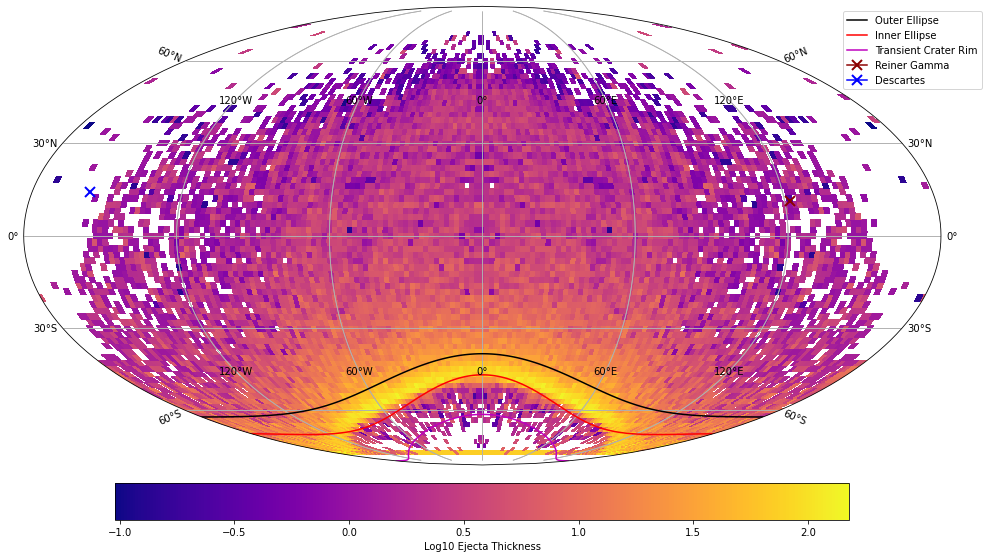

In [33]:
cartopy_plot()

In [33]:

def cartopy_plot_depth():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    depth_min = -180
    depth_max = -30
    bin_size = 50
    for min_range in np.arange(depth_min, depth_max, bin_size):
        
        max_range = min_range + bin_size 
        min_filter = depth > min_range
        max_filter = depth < max_range
        range_filter = min_filter & max_filter #all depths between -180 -160 then -160 to -140
        filtered_lats = land_lats[range_filter]
        filtered_longs = land_longs[range_filter]
        filtered_volume = volume[range_filter]
        filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
        filtered_layer_thickness_log = np.log10(filtered_layer_thickness)

    
        fig = plt.figure(figsize=[14, 14])
        plt.tight_layout()
        ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
        fig.subplots_adjust(bottom=0.05, top=0.95,
                            left=0.04, right=0.95, wspace=0.02)

        # Limit the map to -60 degrees latitude and below.
        ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
        ax1.set_global()
        ax1.gridlines()

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])
        
        Z = np.log10(filtered_layer_thickness)
        plot = ax1.pcolormesh(X, Y, Z, transform=ccrs.PlateCarree(), zorder=3)

        


        cbar = fig.colorbar(plot, label='log10 Thickness (km)', location = 'bottom',shrink = 0.8, pad = 0.02)




        ax1.gridlines(draw_labels = True)
#         plt.show()
        plt.savefig(f'Figures/filtered_thickness_({min_range},{max_range}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')


    
 

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_36190/3948762527.py:16: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_36190/3948762527.py:40: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(filtered_layer_thickness)


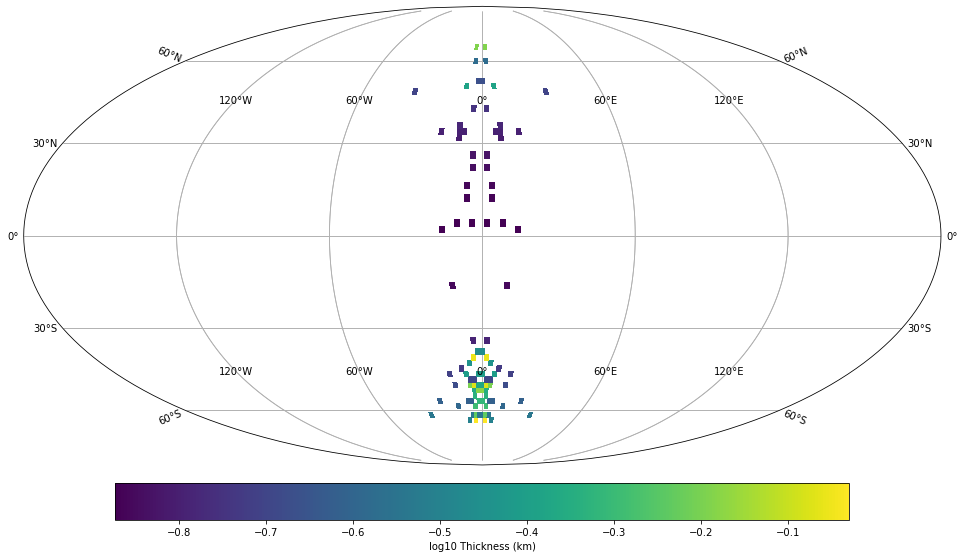

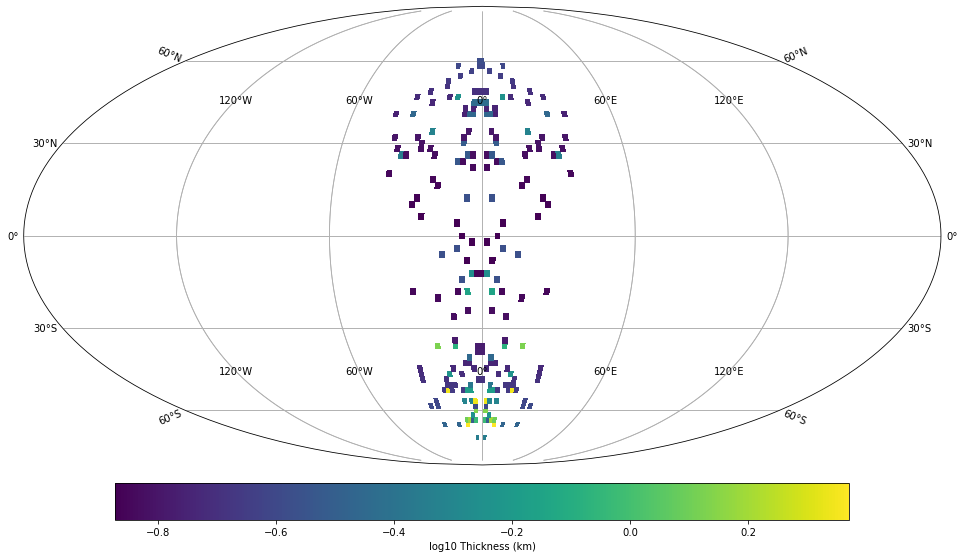

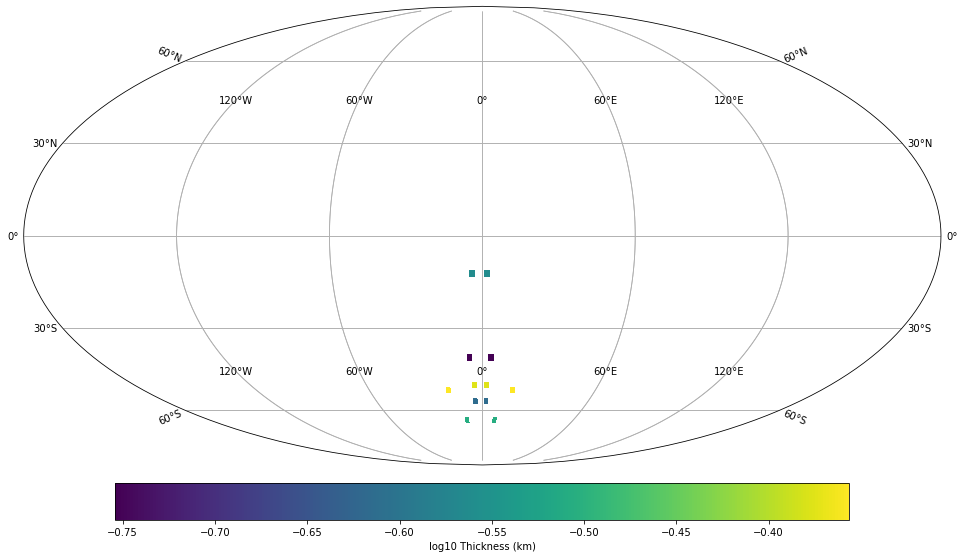

In [34]:
cartopy_plot_depth()

In [31]:
def cartopy_plot_pressure():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    pressure_mins = [0, 5, 10, 25, 50, 100]

    pressure_maxs = [5, 10, 25, 50, 100, pressure.max()]

    pressure_tuple = list(zip(pressure_mins,pressure_maxs))
    
    for min_range, max_range in pressure_tuple:
        min_filter = pressure > min_range
        max_filter = pressure < max_range
        range_filter = min_filter & max_filter 
        filtered_lats = land_lats[range_filter]
        filtered_longs = land_longs[range_filter]
        filtered_volume = volume[range_filter]
        filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
        filtered_layer_thickness_log = np.log10(filtered_layer_thickness)

        fig = plt.figure(figsize=[14, 14])
        plt.tight_layout()
        ax1 = fig.add_subplot(1, 1, 1, projection=ccrs.Mollweide())
        fig.subplots_adjust(bottom=0.05, top=0.95,
                            left=0.04, right=0.95, wspace=0.02)

        # Limit the map to -60 degrees latitude and below.
        ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
        ax1.set_global()
        ax1.gridlines()

        # Compute a circle in axes coordinates, which we can use as a boundary
        # for the map. We can pan/zoom as much as we like - the boundary will be
        # permanently circular.
        theta = np.linspace(0, 2*np.pi, 100)
        center, radius = [0.5, 0.5], 0.5
        verts = np.vstack([np.sin(theta), np.cos(theta)]).T
        circle = mpath.Path(verts * radius + center)

        X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

        Z = np.log10(filtered_layer_thickness)
        lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)
        lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0)
        lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0)
        plot = ax1.pcolormesh(X, Y, Z, transform=ccrs.PlateCarree(), zorder=3, cmap = 'magma')
        ax1.gridlines(draw_labels = True)
        ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2, label = 'Outer Ellipse')
        ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label ='Inner Ellipse')
        ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2, label = 'Transient Crater Rim')
        ax1.plot(-143, 12.97, marker = 'x',c ='darkred',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =3, label = 'Troctolite Sample')
                
        
                
        ax1.legend(bbox_to_anchor=(0.75, 0.5, 0.3, 0.5))
    
   






        cbar = fig.colorbar(plot, label='Log10 Ejecta Thickness', location = 'bottom',shrink = 0.8, pad = 0.02)

    
    
        plt.savefig(f'Figures/filtered_thickness_({min_range},{np.round(max_range)}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')
    
    

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:17: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:40: RuntimeWarning: divide by zero encountered in log10
  Z = np.log10(filtered_layer_thickness)
<__array_function__ internals>:5: UserWarning: Warning: converting a masked element to nan.
/opt/local/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/matplotlib/colors.py:1159: UserWarning: Warning: converting a masked element to nan.
  data = np.asarray(value)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:17: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_1224/1391211517.py:40: RuntimeWarning: divide by zero encountered in l

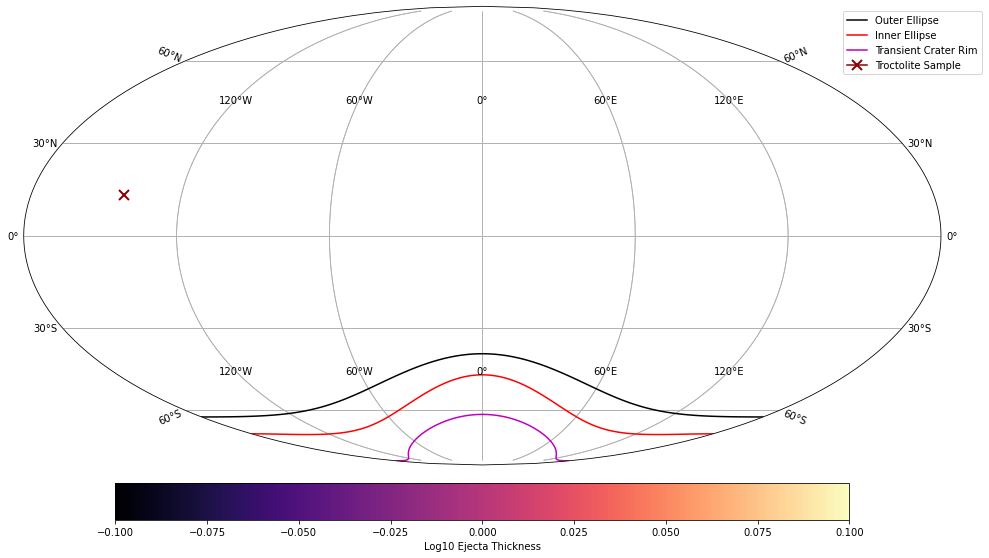

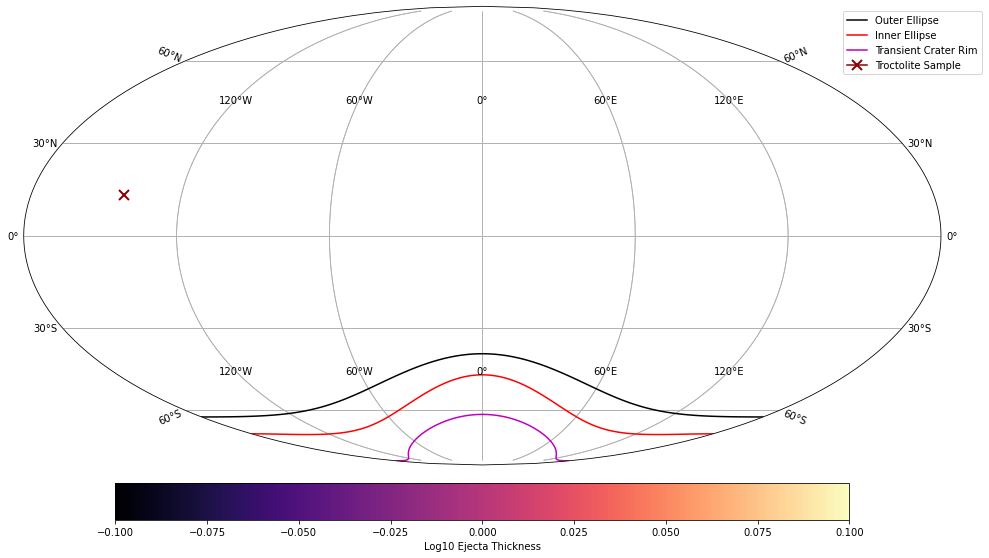

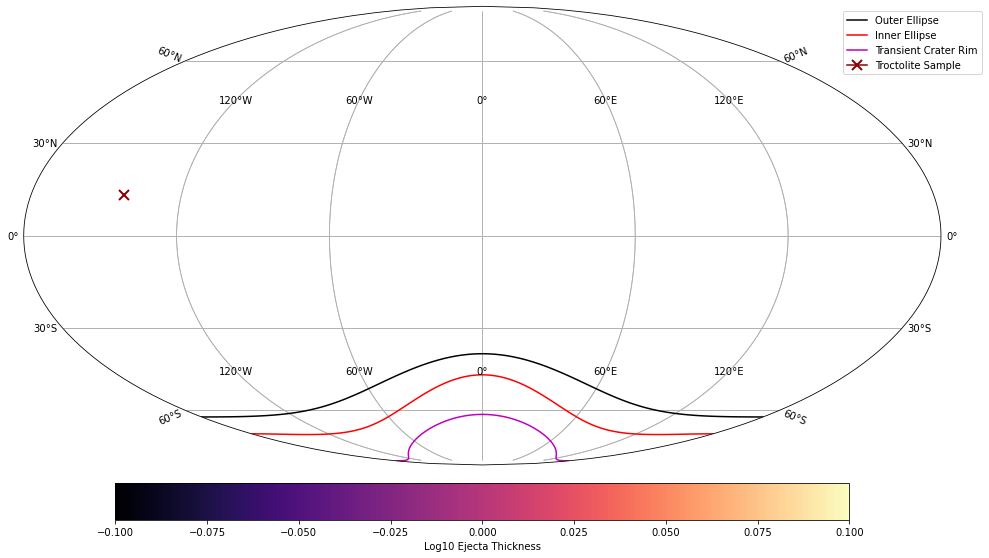

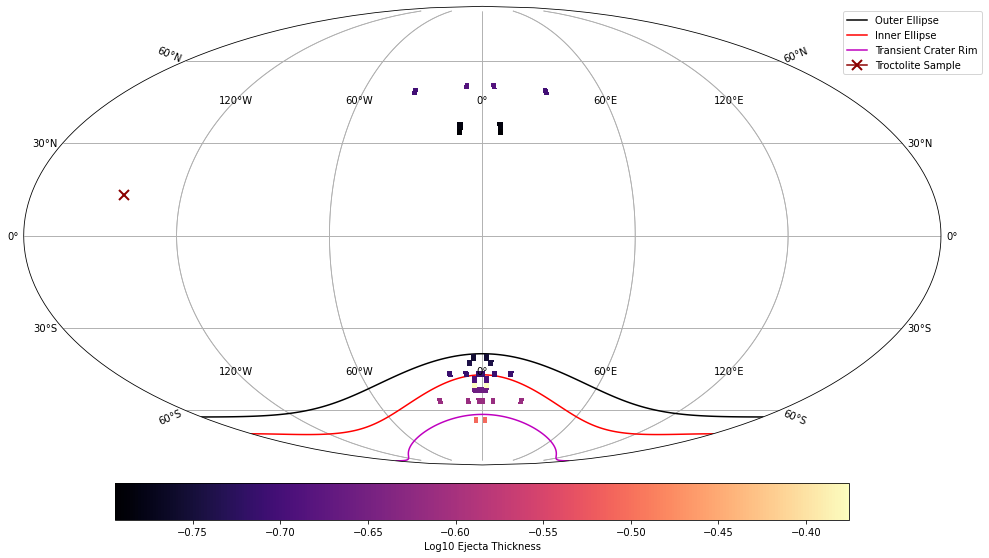

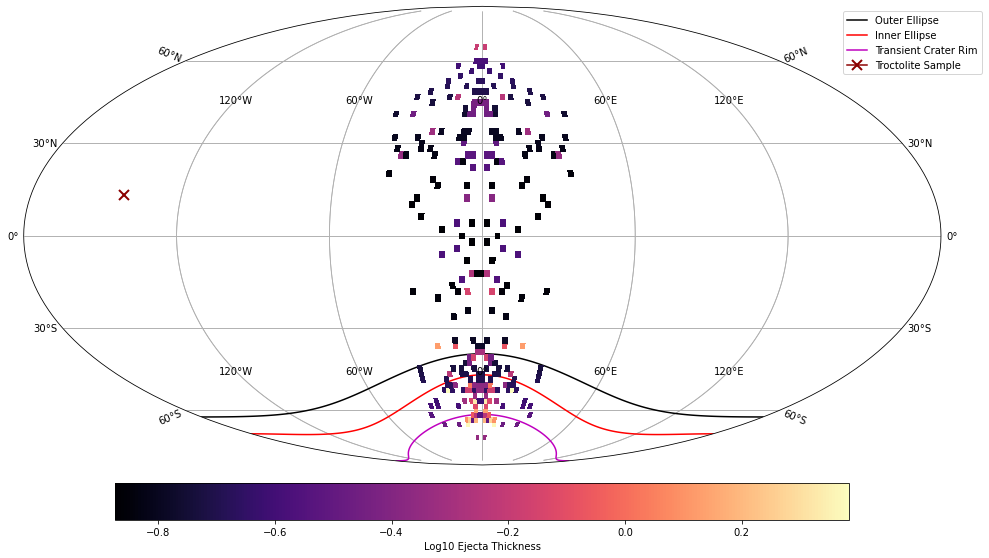

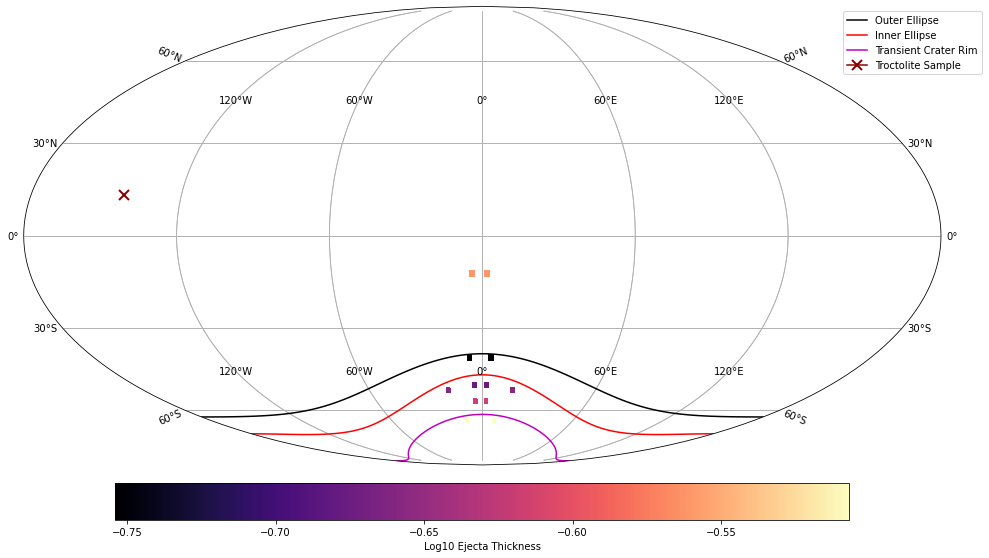

In [32]:
cartopy_plot_pressure()

In [36]:
def thickness_masking(mask):
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    filtered_lats = land_lats[mask]
    filtered_longs = land_longs[mask]
    filtered_volume = volume[mask]
    filtered_layer_thickness, _, _, = binning(filtered_lats, filtered_longs, filtered_volume)
    filtered_layer_thickness_log = np.log10(filtered_layer_thickness)

    return filtered_layer_thickness





In [41]:
def cartopy_plot_nested():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    pressure_mins = [0, 10, 25, 50, 100]
    pressure_maxs = [10, 25, 50, 100, pressure.max()]
    pressure_tuple = list(zip(pressure_mins,pressure_maxs))

    depth_min = 10
    depth_max = 180
    bin_size = 20
    for min_p, max_p in pressure_tuple:
        for min_range in np.arange(depth_min, depth_max, bin_size):
            max_range = min_range + bin_size
            min_filter = depth > min_range
            max_filter = depth < max_range
            depth_filter = min_filter & max_filter
            
            min_filt = pressure > min_p
            max_filt = pressure < max_p
            pressure_filter = min_filt & max_filt
            
    
            final_mask= pressure_filter*depth_filter
            if np.any(np.isin(final_mask, True)) == True:
                layer_thickness_pressure = thickness_masking(pressure_filter)
                layer_thickness_depth = thickness_masking(depth_filter)
                layer_thickness_combined = thickness_masking(final_mask)
            

                fig = plt.figure(figsize=[14, 14])
                plt.tight_layout()
    
                ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.Mollweide())
                ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                fig.subplots_adjust(bottom=0.05, top=0.95,
                                    left=0.04, right=0.95, wspace=0.02)

                # Limit the map to -60 degrees latitude and below.
                ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax2.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax3.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax1.gridlines(draw_labels = True)
                ax2.gridlines(draw_labels = True)
                ax3.gridlines(draw_labels = True)
                ax1.set_global()

                # Compute a circle in axes coordinates, which we can use as a boundary
                # for the map. We can pan/zoom as much as we like - the boundary will be
                # permanently circular.
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)

                X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

                Z1 = np.log10(layer_thickness_pressure)
                Z2 = np.log10(layer_thickness_depth)
                Z3 = np.log10(layer_thickness_combined)
                lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)
                lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0)
                lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0) #transient crater
                
                
    
                plot1 = ax1.pcolormesh(X, Y, Z1, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar1 = plt.colorbar(plot1, label='Log10 Ejecta Thickness', location = 'right', shrink = 0.8,pad = 0.02, ax=ax1, aspect= 10)
                ax1.set_title(f'Pressure Filter: {min_p} to {np.round(max_p)} Gpa')
                plot2 = ax2.pcolormesh(X, Y, Z2, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar2 = plt.colorbar(plot2, label='Log10 Ejecta Thickness', location = 'right', shrink = 0.8,pad = 0.02, ax=ax2, aspect= 10)
                ax2.set_title(f'Depth Filter: {min_range} to {np.round(max_range)} km')
                plot3 = ax3.pcolormesh(X, Y, Z3, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar3 = plt.colorbar(plot1, label='Log10 Ejecta Thickness', location = 'right', shrink = 0.8,pad = 0.02, ax=ax3, aspect= 10)
                ax3.set_title('Combined Filter:')
                #plotting the outer ellipse topography
                ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2,label = 'Outer Ellipse')
                ax2.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                
                #plotting the inner ellipse topography
                ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2, label = 'Inner Ellipse')
                ax2.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
              
                #plotting the transient crater
                ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2,label = 'Transient Crater Rim')
                ax2.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                #plotting the troctolite sample
                ax1.plot(-139, 45, marker = 'x',c ='darkred',ms=10,mew= 2, transform=ccrs.Geodetic(), zorder =3, label = 'Troctolite Sample')
                ax2.plot(-139, 45,marker = 'x', c='darkred',ms=10,mew= 2,transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(-139, 45,marker = 'x', c='darkred',ms=10,mew= 2,transform=ccrs.Geodetic(), zorder =2)
                ax1.legend(loc = 'upper right', bbox_to_anchor=(0.8, 0.7, 0.3, 0.5))
                
                
                
            
                
                
                plt.savefig(f'Figures/filtered_thickness__depth({min_range},{np.round(max_range)}),_pressure({min_p},{max_p}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')






/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716

/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:57: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_pressure)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:58: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_depth)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716585.py:59: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_combined)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_56358/203716

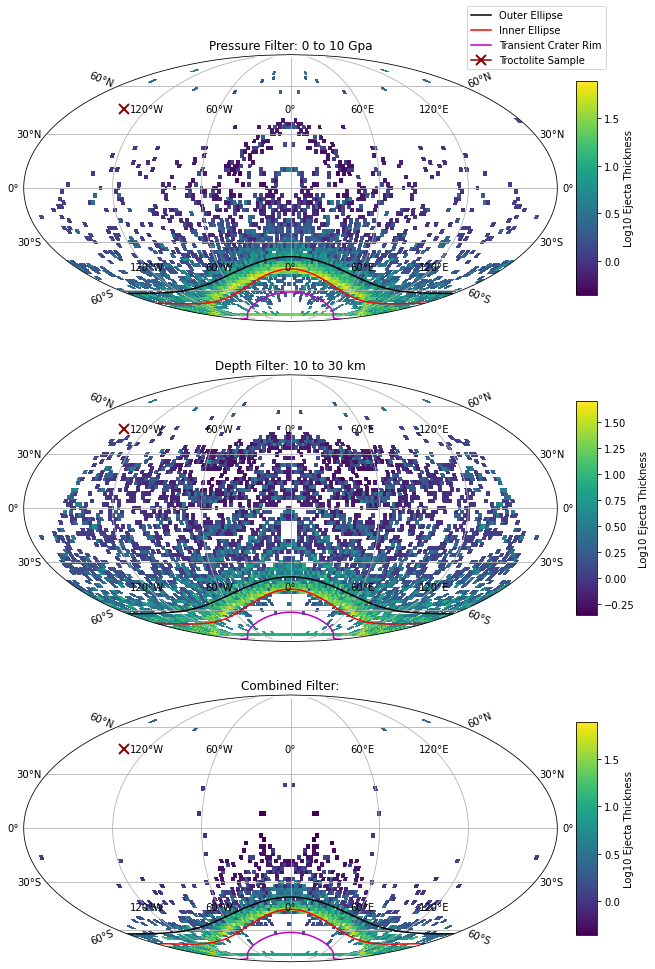

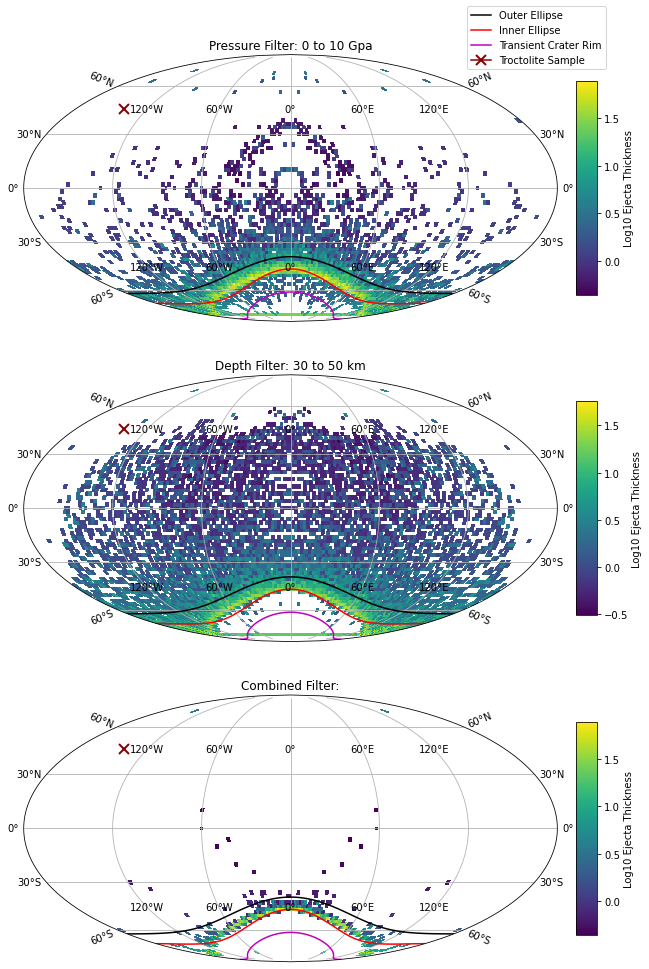

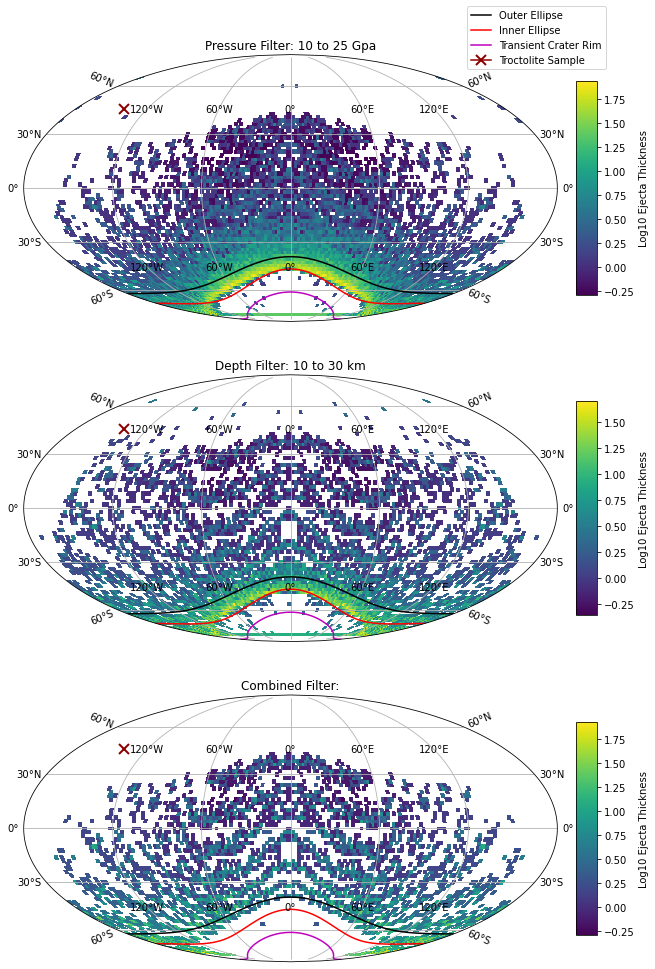

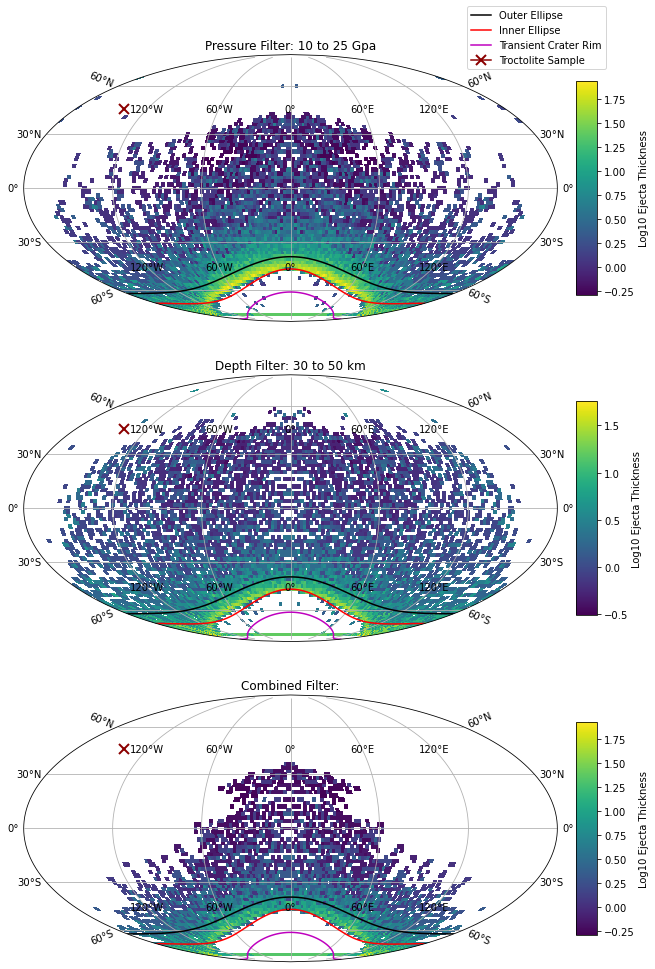

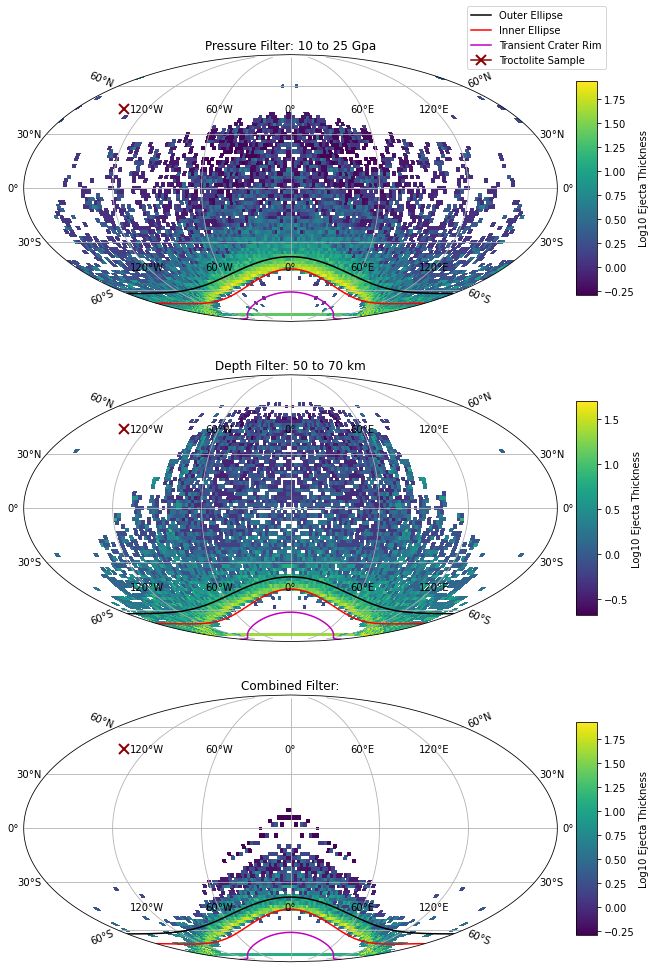

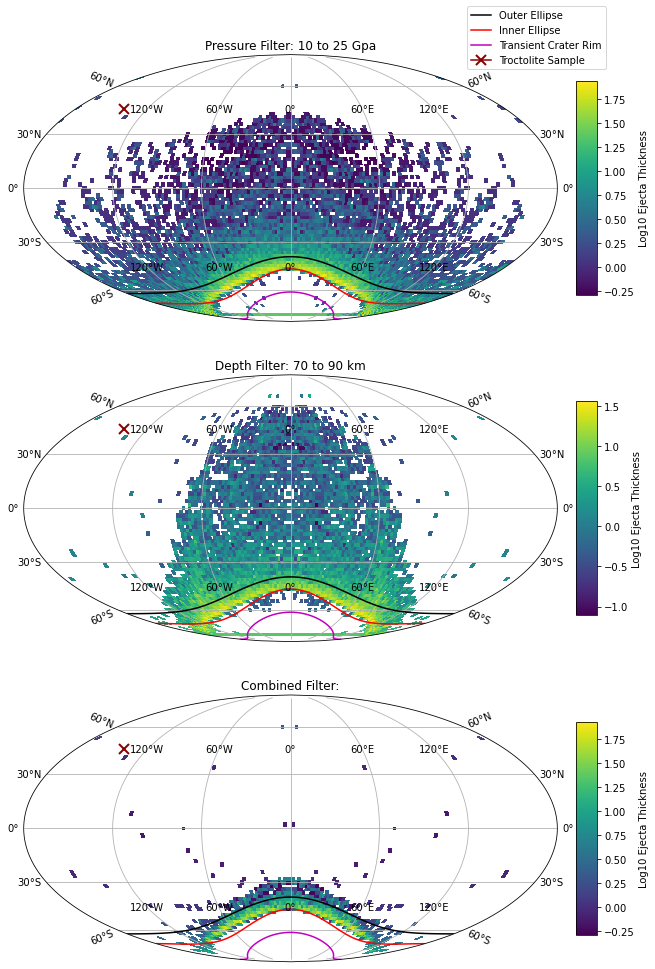

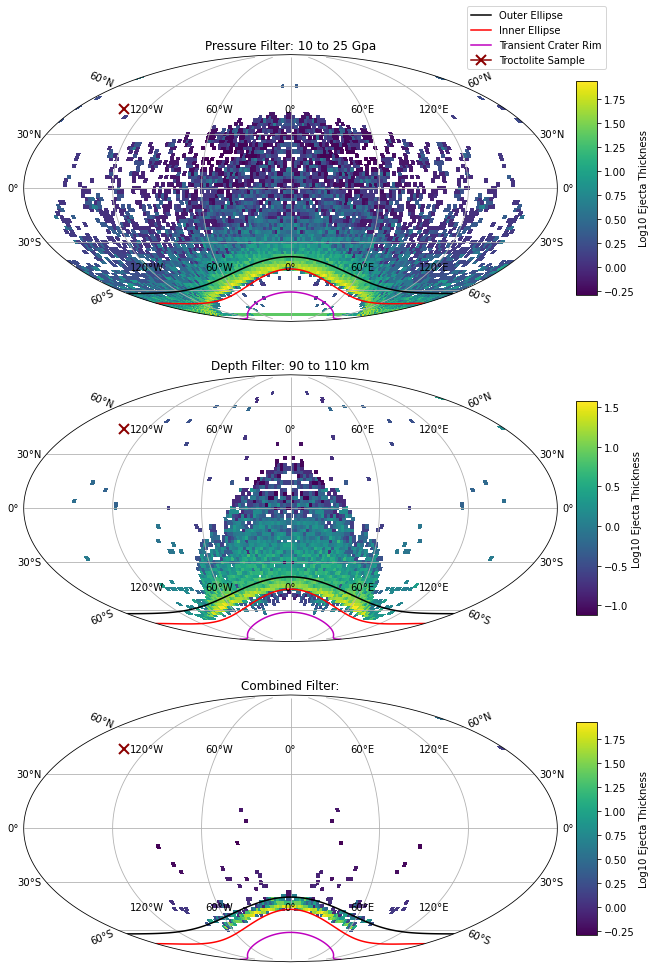

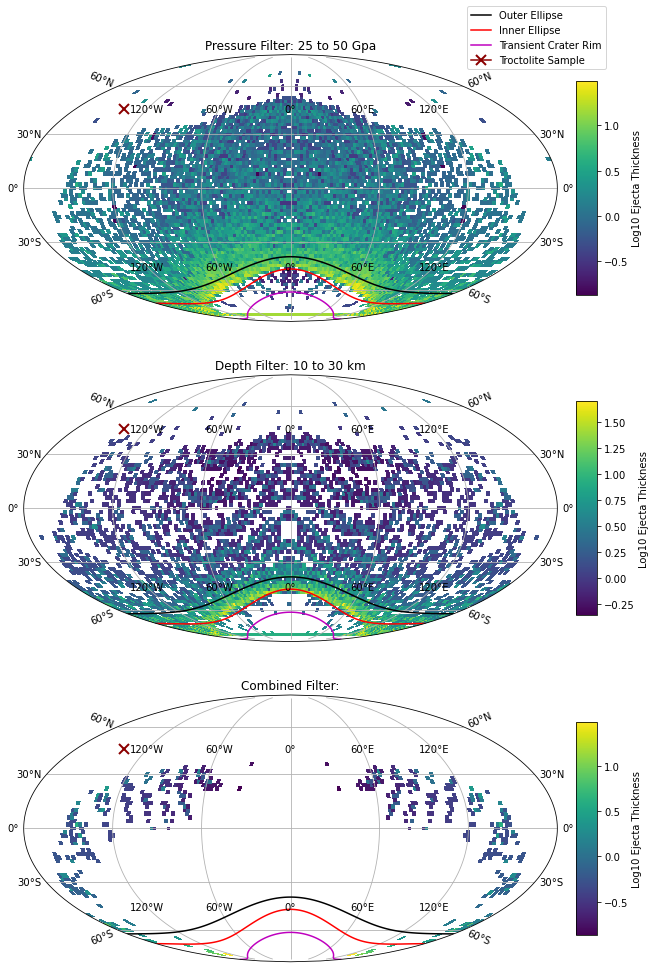

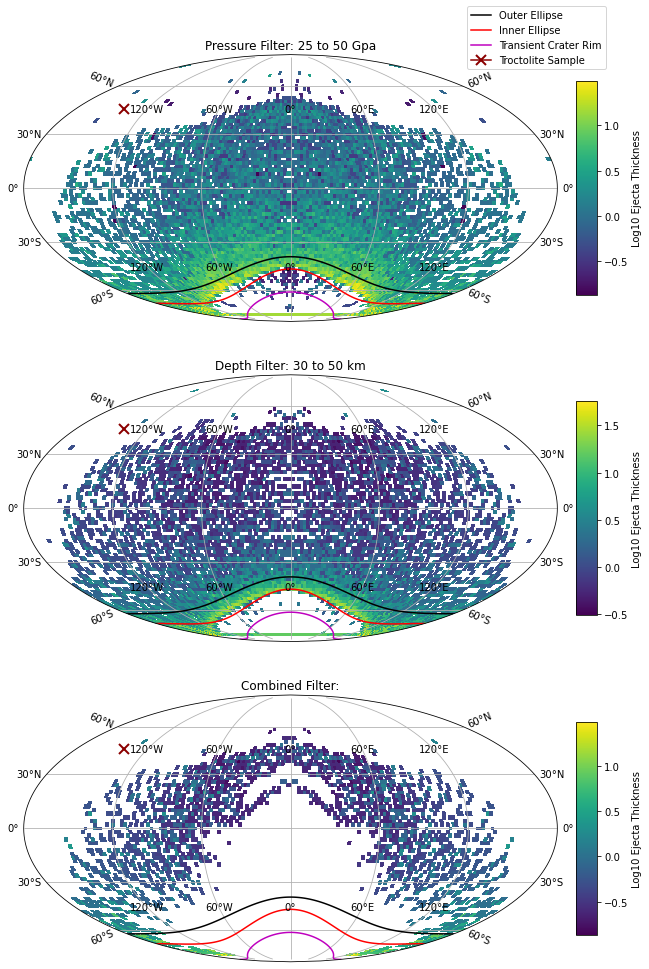

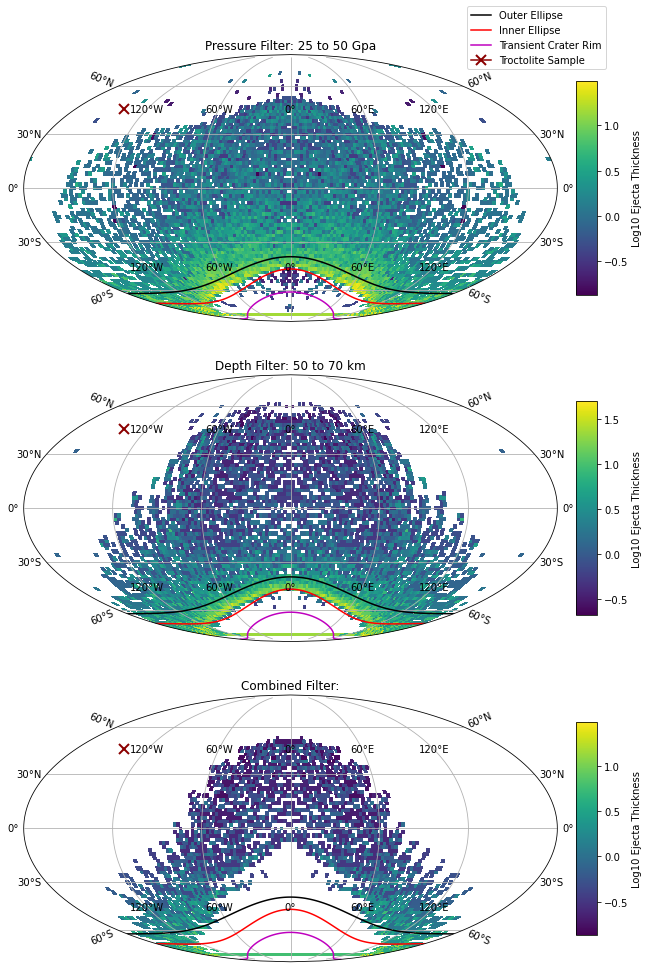

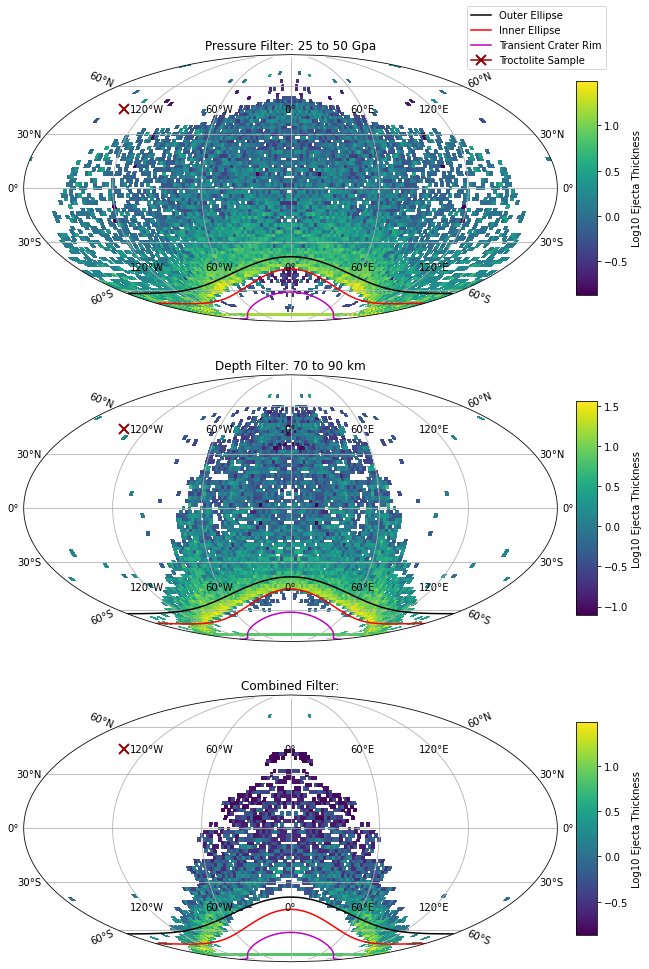

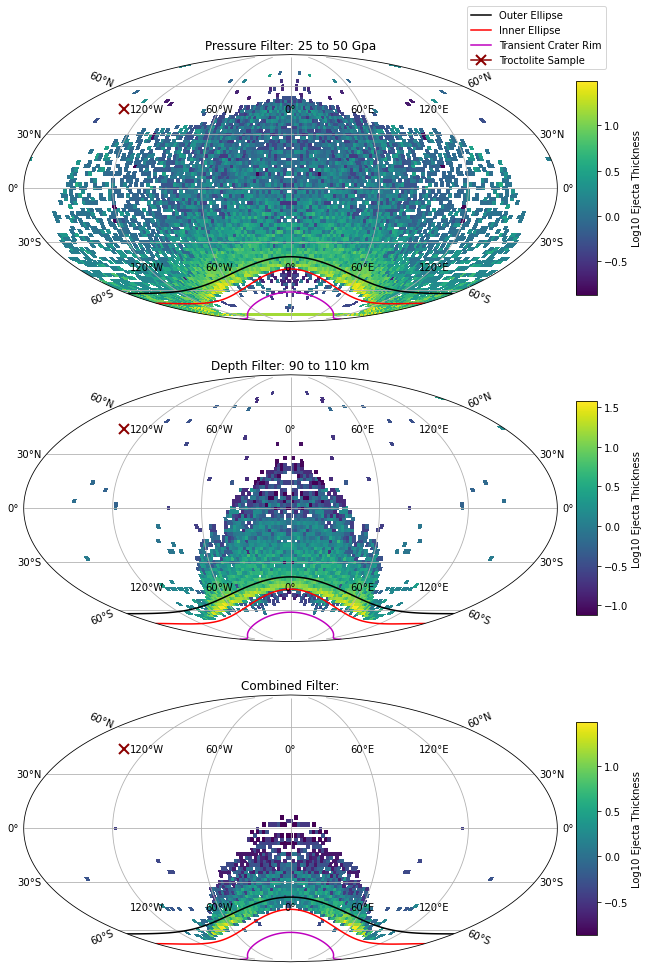

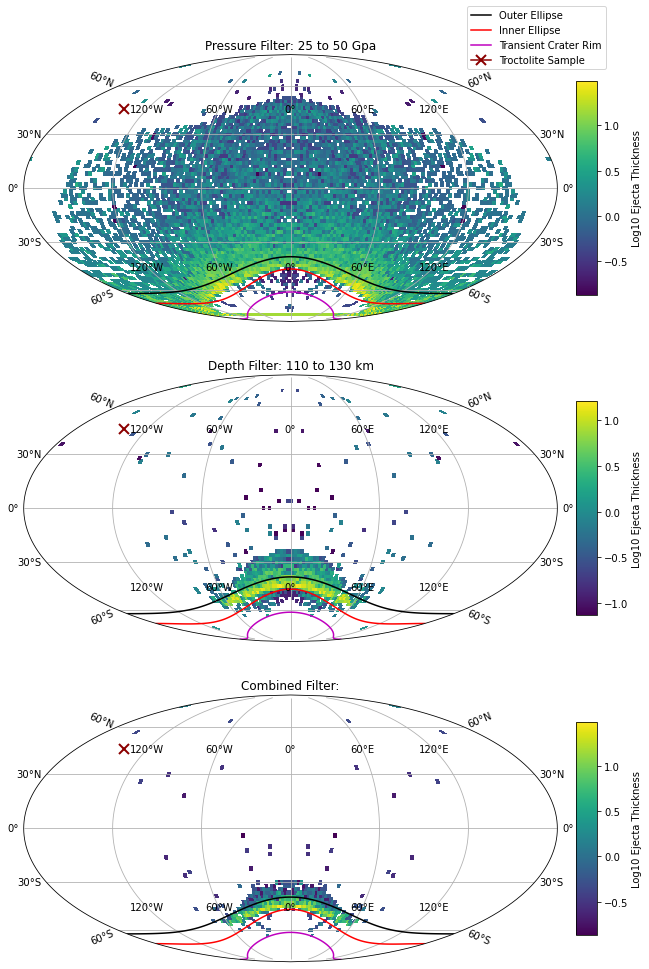

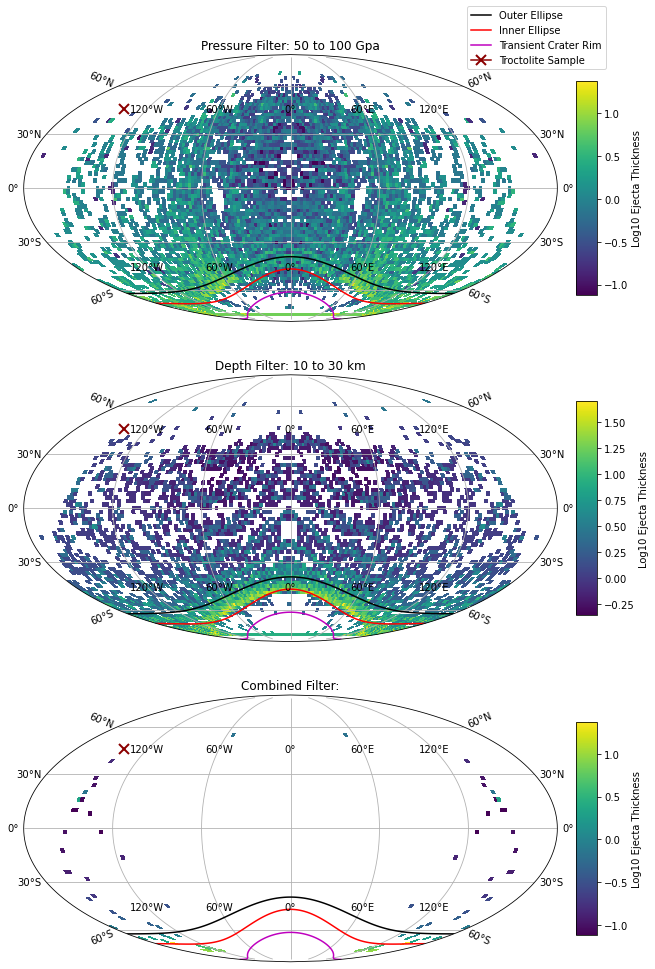

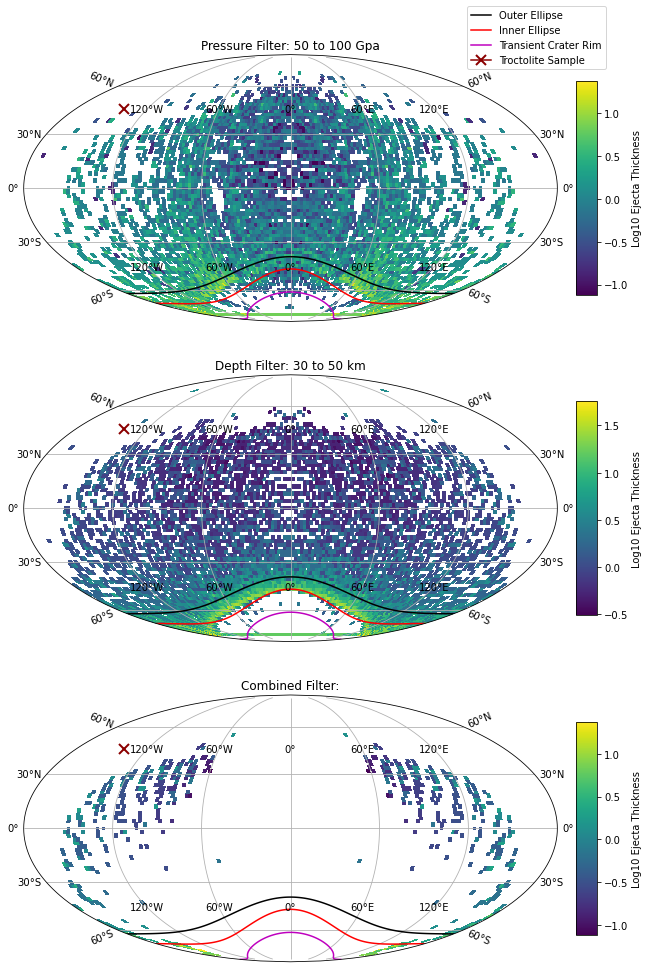

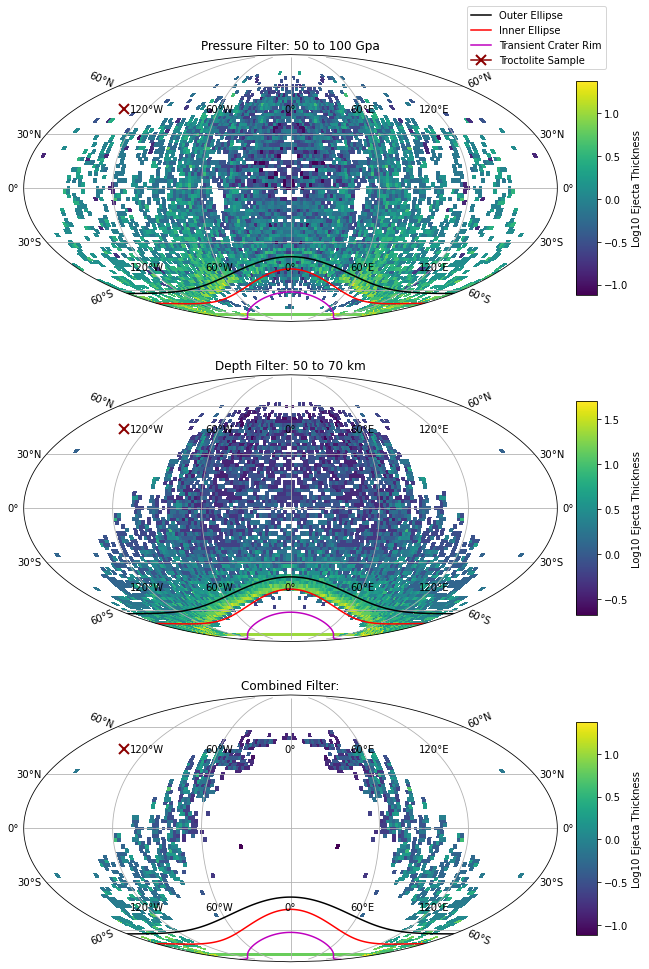

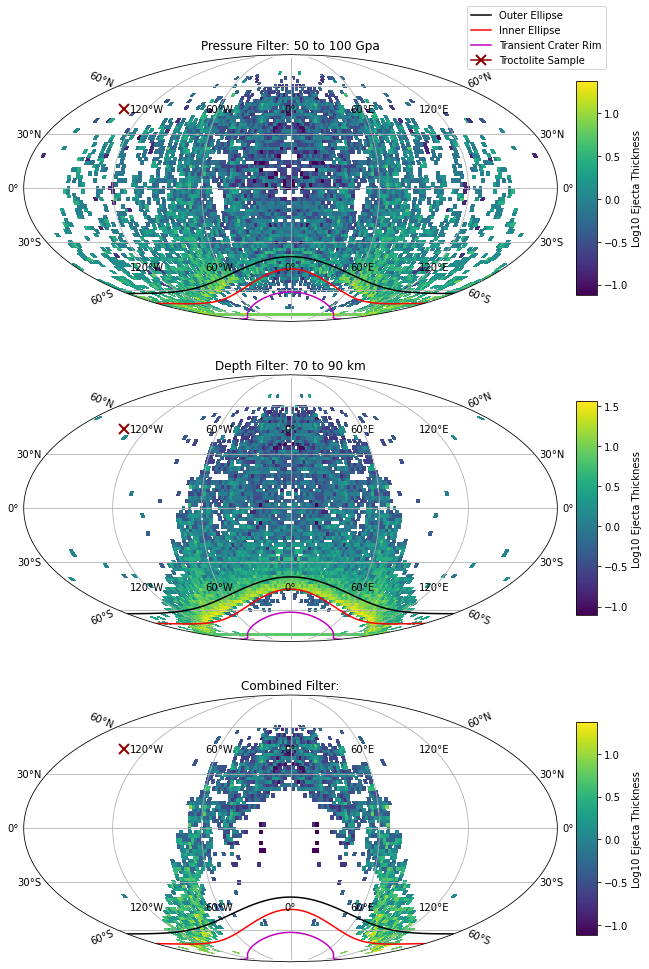

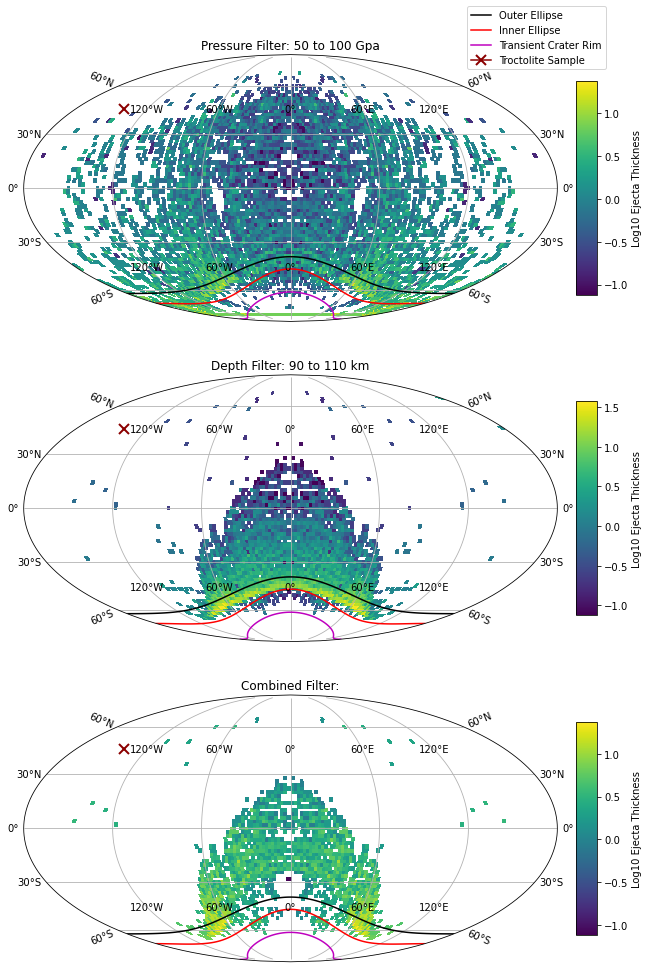

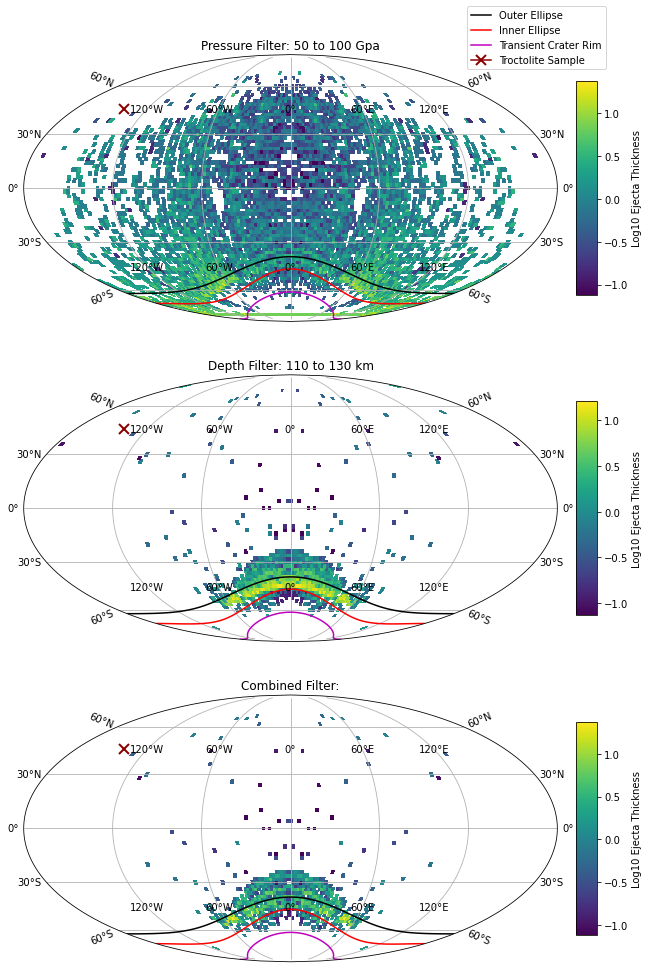

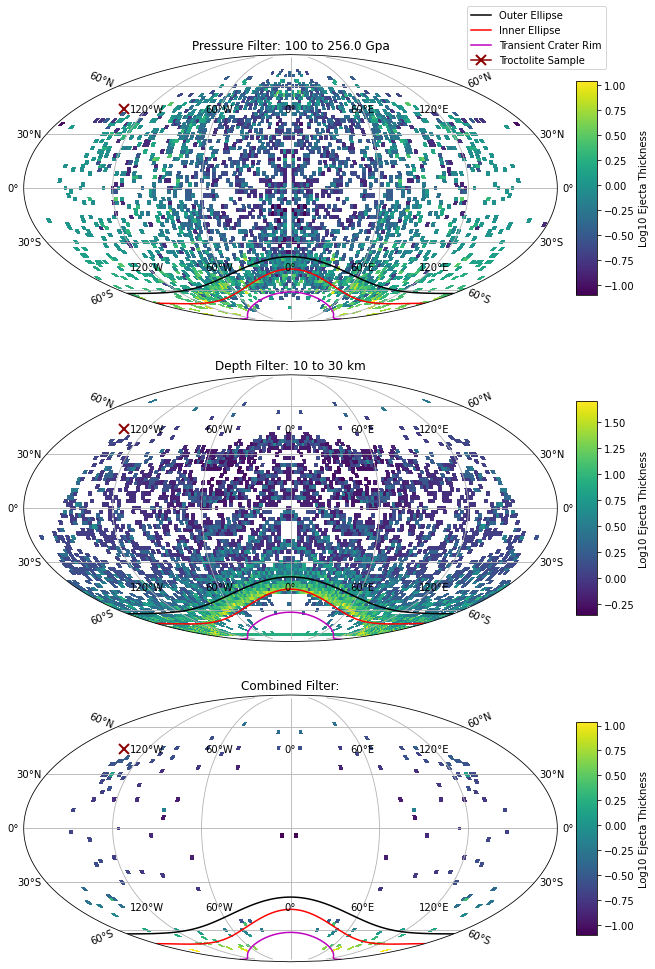

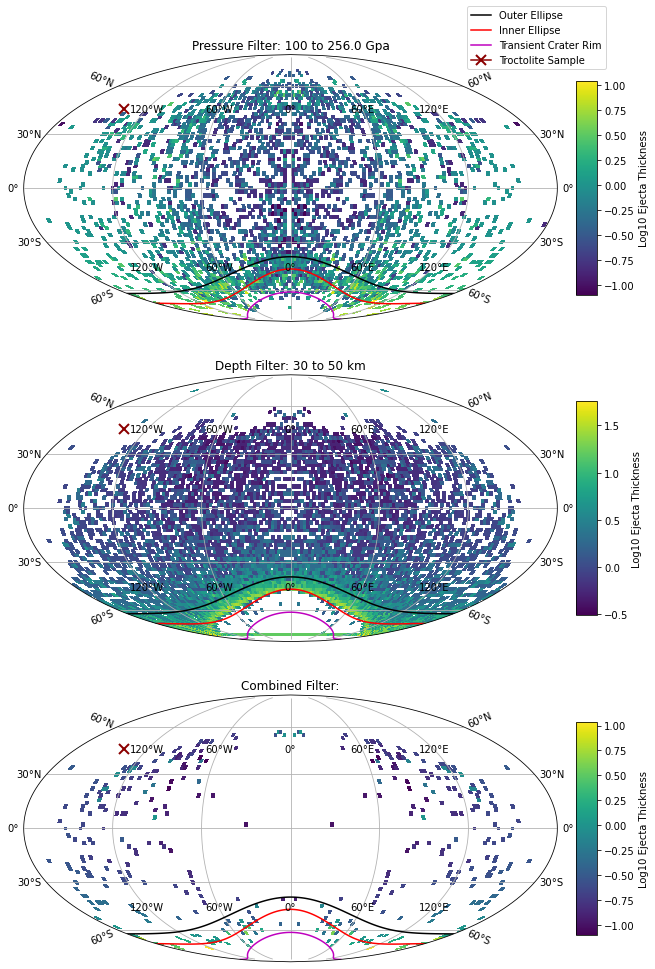

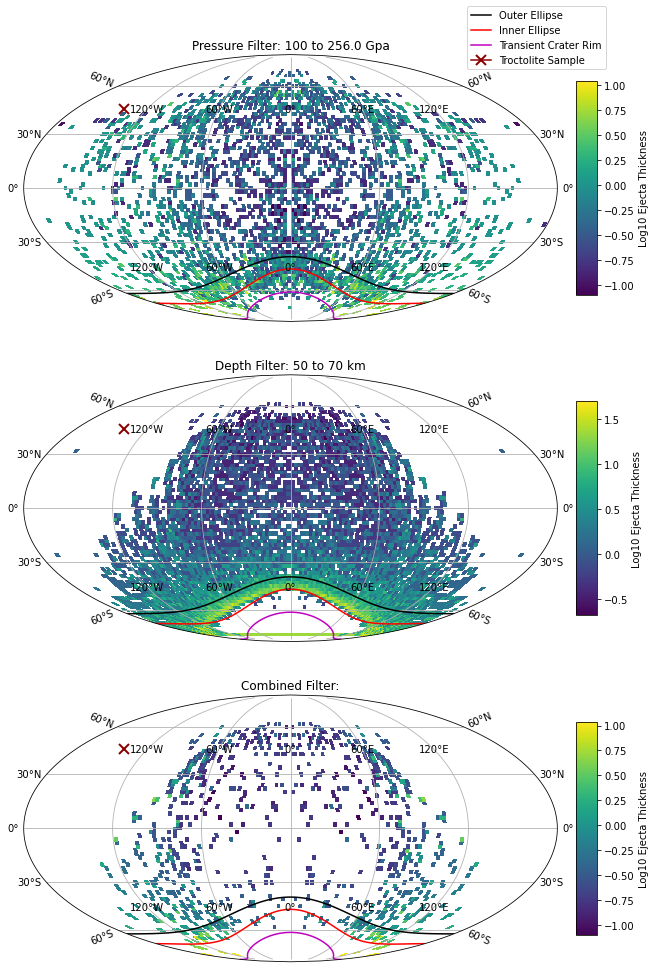

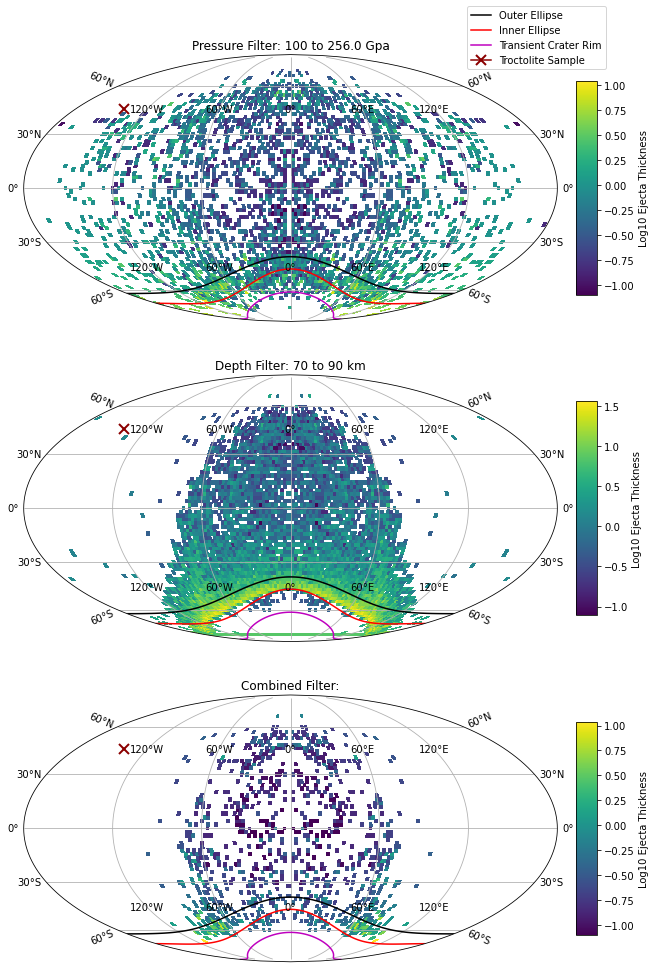

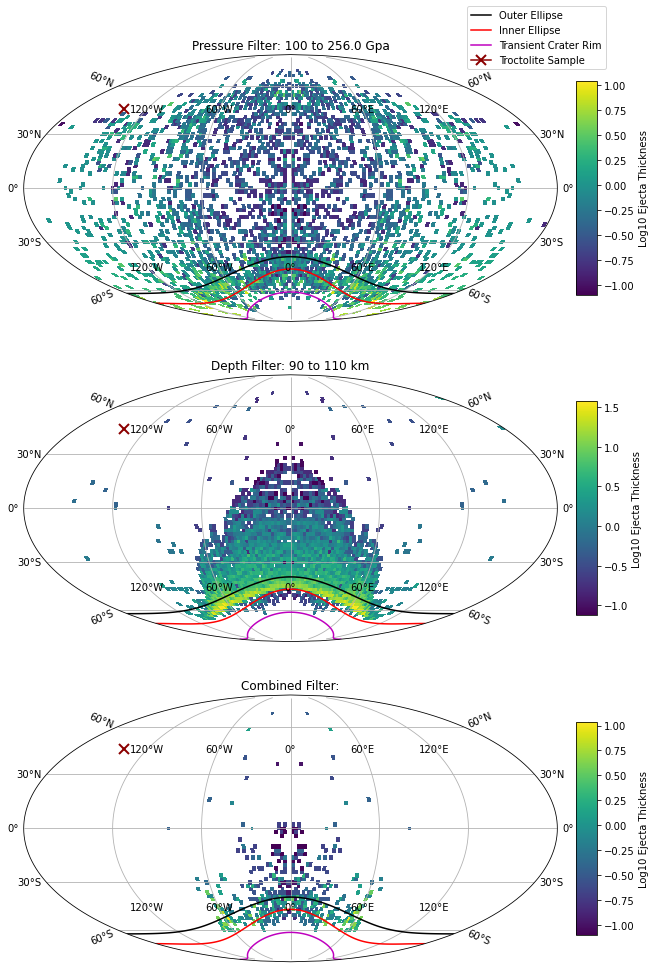

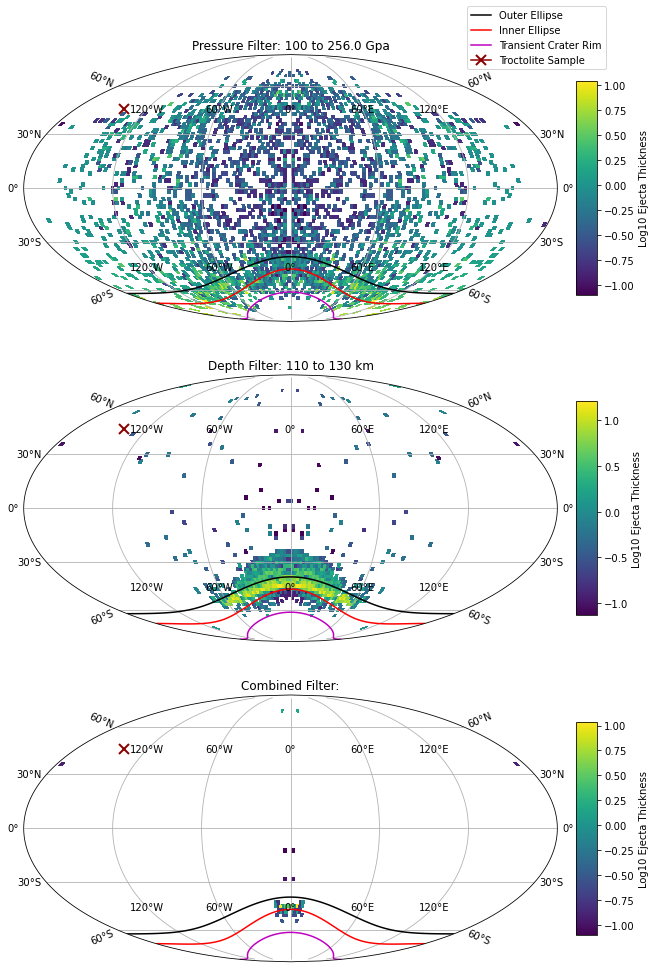

In [42]:
cartopy_plot_nested()

In [24]:
def cartopy_depth_stack():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    for min_range in np.arange(0, 50, 50):
        max_range = min_range + 50
        min_filter = depth > min_range
        max_filter = depth < max_range
        depth_filter1 = min_filter & max_filter
        for min_range2 in np.arange(50, 100, 50):
            max_range2 = min_range2 + 50
            min_filter2 = depth > min_range2
            max_filter2 = depth < max_range2
            depth_filter2 = min_filter2 & max_filter2
            for min_range3 in np.arange(100, depth.max(),50):
                max_range3 = min_range3 + 50
                min_filter3 = depth > min_range3
                max_filter3 = depth < max_range3
                depth_filter3 = min_filter3 & max_filter3
                
                layer_thickness_d1 = thickness_masking(depth_filter1)
                layer_thickness_d2 = thickness_masking(depth_filter2)
                layer_thickness_d3 = thickness_masking(depth_filter3)
                
                
                
                fig = plt.figure(figsize=[14, 14])
                plt.tight_layout()
    
                ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.Mollweide())
                ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                fig.subplots_adjust(bottom=0.05, top=0.95,
                                    left=0.04, right=0.95, wspace=0.02)

                # Limit the map to -60 degrees latitude and below.
                ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax2.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax3.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax1.gridlines(draw_labels = True)
                ax2.gridlines(draw_labels = True)
                ax3.gridlines(draw_labels = True)
                ax1.set_global()

                # Compute a circle in axes coordinates, which we can use as a boundary
                # for the map. We can pan/zoom as much as we like - the boundary will be
                # permanently circular.
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)

                X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

                Z1 = np.log10(layer_thickness_d1)
                Z2 = np.log10(layer_thickness_d2)
                Z3 = np.log10(layer_thickness_d3)
                lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0) #inner topography ellipse
                lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0) #outer topography ellipse
                lats3, lons3 = define_ellipse(-78, 0, 500, 440, 0) #transient crater
                
    
                plot1 = ax1.pcolormesh(X, Y, Z1, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar1 = plt.colorbar(plot1, label='Log10 Ejecta Thickness', location = 'right', shrink = 0.8,pad = 0.02, ax=ax1, aspect= 10)
                ax1.set_title('Depth: 0-50 km')
                plot2 = ax2.pcolormesh(X, Y, Z2, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar2 = plt.colorbar(plot2, label='Log10 Ejecta Thickness', location = 'right', shrink = 0.8,pad = 0.02, ax=ax2, aspect= 10)
                ax2.set_title('Depth: 50-100 km')
                plot3 = ax3.pcolormesh(X, Y, Z3, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar3 = plt.colorbar(plot1, label='Log10 Ejecta Thickness', location = 'right', shrink = 0.8,pad = 0.02, ax=ax3, aspect= 10)
                ax3.set_title('Depth: 100+ km')
                ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax1.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons3, lats3, 'm-', transform=ccrs.Geodetic(), zorder =2)
                
                ax1.legend()
                
                
                
                plt.savefig(f'Figures/depth_stack_v15cold.png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')





                
            
            





/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_33439/1965794491.py:7: RuntimeWarning: divide by zero encountered in log10
  filtered_layer_thickness_log = np.log10(filtered_layer_thickness)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_33439/3546348598.py:53: RuntimeWarning: divide by zero encountered in log10
  Z1 = np.log10(layer_thickness_d1)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_33439/3546348598.py:54: RuntimeWarning: divide by zero encountered in log10
  Z2 = np.log10(layer_thickness_d2)
/var/folders/0x/zddztcdx7tqf3yk2ypkdy1h00000gn/T/ipykernel_33439/3546348598.py:55: RuntimeWarning: divide by zero encountered in log10
  Z3 = np.log10(layer_thickness_d3)
No handles with labels found to put in legend.


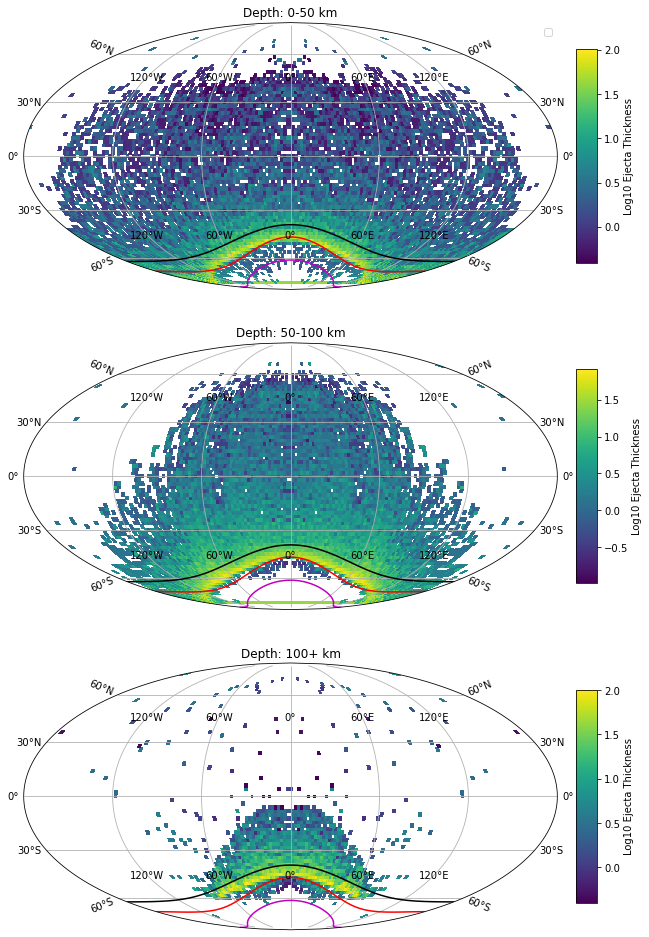

In [25]:
cartopy_depth_stack()


In [34]:
def cartopy_plot_material():
    layer_thickness, final_latitude_bins, final_longitude_bins, = binning(land_lats, land_longs, volume)
    pressure_mins = [0, 5, 10, 25, 50, 100]
    pressure_maxs = [5, 10, 25, 50, 100, pressure.max()]
    pressure_tuple = list(zip(pressure_mins,pressure_maxs))
    depth_min = 0
    depth_max = 100
    bin_size = 25
    for min_p, max_p in pressure_tuple:
        for min_range in np.arange(depth_min, depth_max, bin_size):
            max_range = min_range + bin_size
            min_filter = depth > min_range
            max_filter = depth < max_range

            depth_filter = min_filter & max_filter
            
            min_filt = pressure > min_p
            max_filt = pressure < max_p
            pressure_filter = min_filt & max_filt
            
            
            
    
            final_mask= pressure_filter*depth_filter
            if np.any(np.isin(final_mask, True)) == True:
                layer_thickness_pressure = thickness_masking(pressure_filter)
                layer_thickness_depth = thickness_masking(depth_filter)
                layer_thickness_combined = thickness_masking(final_mask)
            

                fig = plt.figure(figsize=[14, 14])
                plt.tight_layout()
    
                ax1 = fig.add_subplot(3, 1, 1, projection=ccrs.Mollweide())
                ax2 = fig.add_subplot(3, 1, 2, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                ax3 = fig.add_subplot(3, 1, 3, projection=ccrs.Mollweide(), sharex = ax1, sharey = ax1)
                fig.subplots_adjust(bottom=0.05, top=0.95,
                                    left=0.04, right=0.95, wspace=0.02)

                # Limit the map to -60 degrees latitude and below.
                ax1.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax2.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax3.set_extent([-90,90 , 0, 90], ccrs.PlateCarree())
                ax1.gridlines(draw_labels = True)
                ax2.gridlines(draw_labels = True)
                ax3.gridlines(draw_labels = True)
                ax1.set_global()

                # Compute a circle in axes coordinates, which we can use as a boundary
                # for the map. We can pan/zoom as much as we like - the boundary will be
                # permanently circular.
                theta = np.linspace(0, 2*np.pi, 100)
                center, radius = [0.5, 0.5], 0.5
                verts = np.vstack([np.sin(theta), np.cos(theta)]).T
                circle = mpath.Path(verts * radius + center)

                X,Y = np.meshgrid(final_longitude_bins[:-1], final_latitude_bins[:-1])

                Z1 = np.log10(layer_thickness_pressure)
                Z2 = np.log10(layer_thickness_depth)
                Z3 = np.log10(layer_thickness_combined)
                lats1, lons1 = define_ellipse(-78, 0, 970, 720, 0)
                lats2, lons2 = define_ellipse(-78, 0, 1200, 1028, 0)
                
    
                plot1 = ax1.pcolormesh(X, Y, Z1, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar1 = plt.colorbar(plot1, label='log10 Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax1, aspect= 10)
                plot2 = ax2.pcolormesh(X, Y, Z2, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar2 = plt.colorbar(plot2, label='log10 Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax2, aspect= 10)
                plot3 = ax3.pcolormesh(X, Y, Z3, transform=ccrs.PlateCarree(), zorder=1, cmap = 'viridis')
                cbar3 = plt.colorbar(plot1, label='log10 Thickness (km)', location = 'right', shrink = 0.8,pad = 0.02, ax=ax3, aspect= 10)
                ax1.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons1, lats1, 'r-', transform=ccrs.Geodetic(), zorder =2)
                ax1.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax2.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                ax3.plot(lons2, lats2, 'k-', transform=ccrs.Geodetic(), zorder =2)
                
                plt.suptitle('Layer Thickness models: Pressure, Depth, Combined')
                plt.savefig(f'Figures/material_({min_range},{np.round(max_range)},{min_p},{max_p}).png' , dpi = 600, facecolor = 'w', bbox_inches = 'tight')




In [36]:
cartopy_plot_material()

54.82759400304863


(2.0, 2.5)

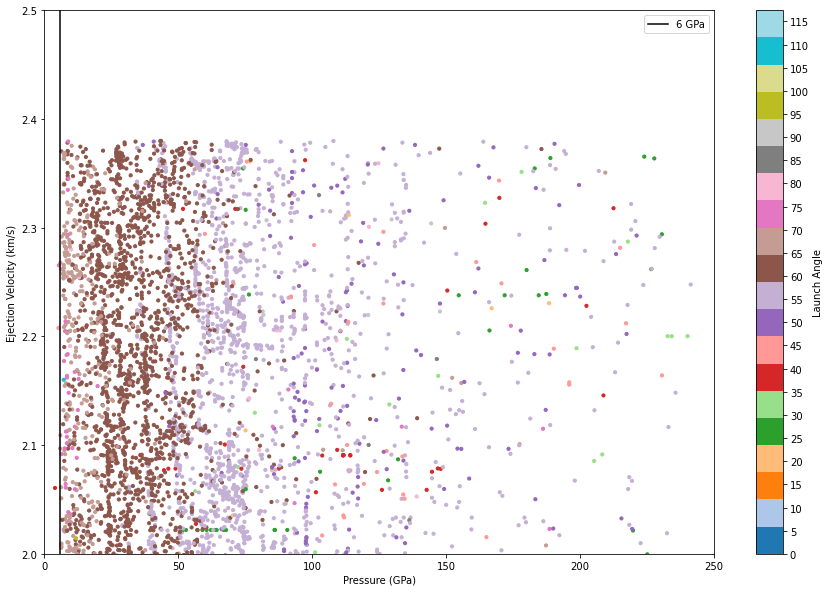

In [168]:
print(np.median(launch_angle))
plt.rcParams["figure.figsize"] = (15,10)
p = pressure
cmap = dict()
plt.scatter(p, velocity, s = 10, c = launch_angle, cmap = 'tab20')
plt.axvline(x = 6, color = 'k', label = '6 GPa')
plt.legend()
ticks = np.arange(0, launch_angle.max(), 5)
plt.clim(0, launch_angle.max())
plt.colorbar(label = 'Launch Angle', ticks=ticks)
plt.xlabel('Pressure (GPa)')
plt.ylabel('Ejection Velocity (km/s)')

plt.xlim(0, 250, 5)
plt.ylim(2 ,2.5)
# plt.savefig('Figures/troctolite_analysis.png', dpi = 600, facecolor = 'white')